# 模型构建

## 导入包

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#pd.set_option('max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [7]:
import sklearn
import math
from math import sqrt
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [8]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import (precision_score, recall_score,f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

In [10]:
def ratio_CI(r,n):
    #z = -ndtri((1.0-0.95)/2)
    z = 1.96
    upper = r+z*sqrt(r*(1-r)/n)
    upper = round(upper,4)
    lower = r-z*sqrt(r*(1-r)/n)
    lower = round(lower,4)
    return upper, lower

def confidence_interval(cm):
    Sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
    n_sens = (cm[1][1]+cm[1][0])
    Specificity = cm[0][0]/(cm[0][0]+cm[0][1])
    n_spec = (cm[0][0]+cm[0][1])
    Accuracy = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1])
    n_acc = cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1]
    
    sens_ = ratio_CI(Sensitivity,n_sens)
    spec_ = ratio_CI(Specificity,n_spec)
    acc_ = ratio_CI(Accuracy,n_spec)
    
    print('Sensitivity[CI]:%.4f [%.4f,%.4f]'%(Sensitivity,sens_[1],sens_[0]))
    print('Specificity[CI]:%.4f [%.4f,%.4f]'%(Specificity,spec_[1],spec_[0]))
    print('Accuracy[CI]:%.4f [%.4f,%.4f]'%(Accuracy,acc_[1],acc_[0]))
    print('PPV:%.4f'%(cm[1][1]/(cm[1][1]+cm[0][1])))
    print('NPV:%.4f'%(cm[0][0]/(cm[0][0]+cm[1][0])))

In [11]:
17/(17+74)

0.18681318681318682

In [12]:
ratio_CI(17/(17+74),(17+74))

(0.2669, 0.1067)

In [13]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

In [14]:
def plot_cm(labels, predictions, p=None):
    if p == None:
        p = Find_Optimal_Cutoff(labels, predictions)[0]
    else:
        p = p
    cm = confusion_matrix(labels, predictions > p)
    auc = roc_auc_score(labels,predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d",cmap = 'GnBu_r')
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label', fontsize = 12)
    plt.xlabel('Predicted label',fontsize = 12)
    
    print('True Negatives: ', cm[0][0])
    print('False totitives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True totitives: ', cm[1][1])
    print('Total: ', np.sum(cm[1]))
    print('-------------------------------')
    print('True Negatives Ratio: %s%%'%str(round((cm[0][0]/(cm[0][0]+cm[0][1]))*100,2)))
    print('False totitives Ratio: %s%%'%str(round((cm[0][1]/(cm[0][0]+cm[0][1]))*100,2)))
    print('False Negatives Ratio: %s%%'%str(round((cm[1][0]/(cm[1][1]+cm[1][0]))*100,2)))
    print('True totitives Ratio: %s%%'%str(round((cm[1][1]/(cm[1][1]+cm[1][0]))*100,2)))
    print('-------------------------------')
    print('AUC:', auc)
    print('Accuracy:', (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1]))
    print('Precision:', cm[1][1]/(cm[1][1]+cm[0][1]))
    print('F1 score', cm[1][1]/(cm[1][1]+1/2*(cm[0][1]+cm[1][0])))
    print('-------------------------------')
    print('-------------------------------')
    confidence_interval(cm)

In [15]:
dev_df = pd.read_csv('dev_df_revise.csv')
val_df = pd.read_csv('val_df_revise.csv')

In [16]:
dev_df['bun'].describe()

count    23506.000000
mean        28.837191
std         23.443175
min          1.000000
25%         14.000000
50%         21.000000
75%         35.000000
max        260.000000
Name: bun, dtype: float64

## 数据准备

In [17]:
label_features_dict = {
'stay_chart_included_mdr':['dementia',
 'platelet',
 'phosphate',
 'heart_rate',
 'weight',
 'creatinine',
 'basophils_abs',
 'lymphocytes_abs',
 'icustay_rank',
 'temperature',
 'sodium',
 'history_difficulty_swallowing',
 'los_hosp_beforeicu',
 'hospstay_seq',
 'neutrophils_abs',
 'wbc',
 'mg',
 'NLR',
 'admission_age',
 'history_assistive_devices_Wheelchair',
 'mchc',
 'history_past_COPD',
 'bun',
 'rdw',
 'previous_mdr_90d'
]
}

In [18]:
models_dict_lr_mod = np.load('lr_params_revise.npy',allow_pickle=True).item()
models_dict_knn_mod = np.load('knn_params_revise.npy',allow_pickle=True).item()
models_dict_svc_mod = np.load('svc_params_revise.npy',allow_pickle=True).item()
models_dict_rf_mod = np.load('rf_params_revise.npy',allow_pickle=True).item()
models_dict_xgb_mod = np.load('xgb_params_revise.npy',allow_pickle=True).item()
models_dict_mlp_mod = np.load('mlp_params_revise.npy',allow_pickle=True).item()

## 模型准备

In [19]:
label_names = ['stay_chart_included_mdr']

In [20]:
modelsname = []
for i in label_names:
    for j in ['_lr','_knn','_svc','_rf','_xgb','_mlp']:
        modelsname.append(i+j)

In [21]:
gramtot_lr = LogisticRegression(penalty = 'l2', C = models_dict_lr_mod['stay_chart_included_mdr']['params']['C'], random_state = 2021)

In [22]:
gramtot_knn = KNeighborsClassifier(n_neighbors = models_dict_knn_mod['stay_chart_included_mdr']['params']['n_neighbors'], \
                                       weights=models_dict_knn_mod['stay_chart_included_mdr']['params']['weights'])

In [23]:
gramtot_svc = SVC(C = models_dict_svc_mod['stay_chart_included_mdr']['params']['C'], \
                      gamma = models_dict_svc_mod['stay_chart_included_mdr']['params']['gamma'],probability = True, random_state = 2021)

In [24]:
gramtot_rf = RandomForestClassifier( max_depth = models_dict_rf_mod['stay_chart_included_mdr']['params']['max_depth'],
                                         max_features = models_dict_rf_mod['stay_chart_included_mdr']['params']['max_features'],
                                         min_samples_split = models_dict_rf_mod['stay_chart_included_mdr']['params']['min_samples_split'],
                                         n_estimators = models_dict_rf_mod['stay_chart_included_mdr']['params']['n_estimators'],
                                         random_state = 2021)

In [25]:
gramtot_xgb = XGBClassifier( max_depth = models_dict_xgb_mod['stay_chart_included_mdr']['params']['max_depth'],
                                         subsample = models_dict_xgb_mod['stay_chart_included_mdr']['params']['subsample'],
                                         min_child_weight = models_dict_xgb_mod['stay_chart_included_mdr']['params']['min_child_weight'],
                                         n_estimators = models_dict_xgb_mod['stay_chart_included_mdr']['params']['n_estimators'],learning_rate = 0.01,
                                         random_state = 2021)

In [26]:
gramtot_mlp = MLPClassifier(hidden_layer_sizes = (models_dict_mlp_mod['stay_chart_included_mdr']['params']['layer1'],
                                         models_dict_mlp_mod['stay_chart_included_mdr']['params']['layer2']),
                                         random_state=2021,early_stopping = False)


In [27]:
gramtot_estimators = [
    ('lr',make_pipeline(MinMaxScaler(),
                           gramtot_lr)
     ),
#     ('knn', make_pipeline(MinMaxScaler(),
#                            gramtot_knn)
#     ),
#     ('svc', gramtot_svc
#    ),
    ('rf', gramtot_rf
    ),
    ('xgb', gramtot_xgb
    ),
    ('mlp', make_pipeline(MinMaxScaler(),
                           gramtot_mlp)
    )
]

gramtot_ensemble = StackingClassifier(
     estimators=gramtot_estimators, final_estimator=LogisticRegression(solver='lbfgs', max_iter=300)
 )

In [28]:
model_list = [gramtot_lr,
gramtot_knn,
gramtot_svc,
gramtot_rf,
gramtot_xgb,
gramtot_mlp,
gramtot_ensemble]

In [29]:
modelsname_all = \
['gramtot_lr',
 'gramtot_knn',
 'gramtot_svc',
 'gramtot_rf',
 'gramtot_xgb',
 'gramtot_mlp',
 'gramtot_ensemble'
]

In [30]:
modelsname_all_prob = [i + '_prob' for i in modelsname_all]

In [31]:
def model_test(x_train,y_train,x_ext,y_ext,model):

    if (type(model) == SVC) or (type(model) == LogisticRegression) \
    or (type(model) == MLPClassifier) or (type(model) ==  KNeighborsClassifier):
        scaler = MinMaxScaler()
        x_train = pd.DataFrame(scaler.fit_transform(x_train))
        x_ext = pd.DataFrame(scaler.transform(x_ext))
    
    n_size = len(x_train)
    
    train = pd.concat([x_train,y_train],axis = 1)
    # run bootstrap
    stats = list()
    stats_alldata = list()
    model.fit(x_train,y_train)
    
    predict_int = model.predict_proba(x_train)
    
    predict_ext = model.predict_proba(x_ext)
    
    

    n_iterations = 5
    for i in range(n_iterations):
        # prepare train and test sets
        train_samp = resample(train, n_samples=n_size,replace= True)
        # fit model

        model.fit(train_samp.iloc[:,:-1], train_samp.iloc[:,-1])
        # evaluate model
        predictions = model.predict_proba(train_samp.iloc[:,:-1])
        
        score = roc_auc_score(train_samp.iloc[:,-1],predictions[:,1])
        #print(score)
        stats.append(score)
        
        predict_alldata = model.predict_proba(x_train)
        score_alldata = roc_auc_score(y_train,predict_alldata[:,1])
        stats_alldata.append(score_alldata)
        
    c_optimism = (np.array(stats) - np.array(stats_alldata)).mean()
    c_adjusted = roc_auc_score(y_train,predict_int[:,1]) - c_optimism
    
    # plot scores
    pyplot.hist(stats)
    pyplot.show()

    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    
    stats_mean = np.array(stats)
    print('-------------------------------------------------------------------')
    print('-------------------------------%s-------------------------------'%type(model))
    print('-------------------------------------------------------------------')
    print('训练集初始AUC：%s'%round(roc_auc_score(y_train,predict_int[:,1]),3))
    print('internal validation: bootstrap mean AUC: %.3f, 95%%CI: [%.3f - %.3f]' % (stats_mean.mean(), lower, upper))
    print('internal validation: enhanced bootstrap, over value: %.3f, AUC adjusted: %.3f' % (c_optimism, c_adjusted))
    print('-------------------------------------------------------------------')
    print('外部验证AUC：%s'%round(roc_auc_score(y_ext,predict_ext[:,1]),3))
    print('-------------------------------------------------------------------')
    
    return predict_ext[:,1]

In [32]:
def model_test_simp(x_train,y_train,x_ext,y_ext,model):

    if (type(model) == SVC) or (type(model) == LogisticRegression) \
    or (type(model) == MLPClassifier) or (type(model) ==  KNeighborsClassifier):
        scaler = MinMaxScaler()
        x_train = pd.DataFrame(scaler.fit_transform(x_train))
        x_ext = pd.DataFrame(scaler.transform(x_ext))
    
    n_size = len(x_train)
    
    train = pd.concat([x_train,y_train],axis = 1)
    model.fit(x_train,y_train)
    
    predict_int = model.predict_proba(x_train)
    
    predict_ext = model.predict_proba(x_ext)
    
    print('-------------------------------------------------------------------')
    print('-------------------------------%s-------------------------------'%type(model))
    print('-------------------------------------------------------------------')
    print('训练集初始AUC：%s'%round(roc_auc_score(y_train,predict_int[:,1]),3))
    print('-------------------------------------------------------------------')
    print('外部验证AUC：%s'%round(roc_auc_score(y_ext,predict_ext[:,1]),3))
    print('-------------------------------------------------------------------')
    
    return predict_ext[:,1]

In [33]:
x_train,y_train,x_ext,y_ext = dev_df[label_features_dict['stay_chart_included_mdr']],dev_df['stay_chart_included_mdr'],\
               val_df[label_features_dict['stay_chart_included_mdr']],val_df['stay_chart_included_mdr']

model = MLPClassifier(early_stopping=True, hidden_layer_sizes=(70, 10),
              random_state=2021)

if (type(model) == SVC) or (type(model) == LogisticRegression) \
or (type(model) == MLPClassifier) or (type(model) ==  KNeighborsClassifier):
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_train = pd.DataFrame(x_train)
    x_ext = pd.DataFrame(scaler.transform(x_ext))

model.fit(x_train,y_train)

predict_int = model.predict_proba(x_train)

predict_ext = model.predict_proba(x_ext)

roc_auc_score(y_ext,predict_ext[:,1])

0.5694059806869199

In [34]:
gramtot_predict_dict = {}
gramtot_predict_dict['gramtot_true'] = val_df['stay_chart_included_mdr']
for i in  range(0, 7):
    print(modelsname_all_prob[i])
    gramtot_predict_dict[modelsname_all_prob[i]] = model_test_simp(dev_df[label_features_dict['stay_chart_included_mdr']],dev_df['stay_chart_included_mdr'],\
               val_df[label_features_dict['stay_chart_included_mdr']],val_df['stay_chart_included_mdr'],model_list[i])

gramtot_lr_prob
-------------------------------------------------------------------
-------------------------------<class 'sklearn.linear_model._logistic.LogisticRegression'>-------------------------------
-------------------------------------------------------------------
训练集初始AUC：0.704
-------------------------------------------------------------------
外部验证AUC：0.717
-------------------------------------------------------------------
gramtot_knn_prob
-------------------------------------------------------------------
-------------------------------<class 'sklearn.neighbors._classification.KNeighborsClassifier'>-------------------------------
-------------------------------------------------------------------
训练集初始AUC：1.0
-------------------------------------------------------------------
外部验证AUC：0.7
-------------------------------------------------------------------
gramtot_svc_prob
-------------------------------------------------------------------
-------------------------------<cla

In [35]:
def confidence_interval_new(cm):
    Sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
    n_sens = (cm[1][1]+cm[1][0])
    Specificity = cm[0][0]/(cm[0][0]+cm[0][1])
    n_spec = (cm[0][0]+cm[0][1])
    Accuracy = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1])
    n_acc = cm[1][1] + cm[0][0]+cm[1][0] + cm[0][1]
    PPV = cm[1][1]/(cm[1][1]+cm[0][1])
    n_ppv = (cm[1][1]+cm[0][1])                
    NPV = cm[0][0]/(cm[0][0]+cm[1][0])
    n_npv = (cm[0][0]+cm[1][0])
    
    acc_ = ratio_CI(Accuracy,n_spec)
    sens_ = ratio_CI(Sensitivity,n_sens)
    spec_ = ratio_CI(Specificity,n_spec)
    ppv_ = ratio_CI(PPV,n_ppv)
    npv_ = ratio_CI(NPV,n_npv)
    
    acc_str = str(round(Accuracy*100,2))
    sens_str = str(round(Sensitivity*100,2))
    spec_str = str(round(Specificity*100,2))
    ppv_str = str(round(PPV*100,2))
    npv_str = str(round(NPV*100,2))
    
    return acc_str,sens_str,spec_str,ppv_str,npv_str

In [36]:
fpr, tpr, threshold = roc_curve(gramtot_predict_dict['gramtot_true'], gramtot_predict_dict['gramtot_ensemble_prob'])

cutoff_l = []
num_l = []
acc_l = []
sens_l = []
spec_l = []
ppv_l = []
npv_l = []
for i in threshold:
    gramtot_predict_dict['gramtot_ensemble_prob']>i
    test = pd.DataFrame(gramtot_predict_dict)[['gramtot_true','gramtot_ensemble_prob']]
    test['predict'] = (test['gramtot_ensemble_prob']>i).apply(int)
    cm = confusion_matrix(test['gramtot_true'], test['predict'])
    num = cm[0][1]+cm[1][1]
    acc_str,sens_str,spec_str,ppv_str,npv_str = confidence_interval_new(cm)
    
    cutoff_l.append(i)
    num_l.append(num)
    acc_l.append(acc_str)
    sens_l.append(sens_str)
    spec_l.append(spec_str)
    ppv_l.append(ppv_str)
    npv_l.append(npv_str)
    
all_cutoff = pd.DataFrame({'截断值':cutoff_l,'数量':num_l,'准确率 (%)':acc_l,'灵敏度 (%)':sens_l,'特异度 (%)':spec_l,'阳性预告值 (%)':ppv_l,'阴性预告值 (%)':npv_l})

In [37]:
num_stard = []
t = 0
for i in range(11):
    g = 10685/11
    t = g*i
    num_stard.append(t)

In [38]:
q_find = []
for i in num_stard:
    aa = []
    bb = []

    for j in all_cutoff['数量']:
        de = abs(i- j) 
        aa.append(j)
        bb.append(de)
        
    for m in range(len(bb)):
        if bb[m] == min(bb):
            find_m = m
    for s in range(len(aa)):
         q_find.append(aa[find_m])
    

In [39]:
all_cutoff[all_cutoff['数量'].isin(list(set(q_find)))].sort_values(by = '截断值').reset_index(drop = True).head(10)

,截断值,数量,准确率 (%),灵敏度 (%),特异度 (%),阳性预告值 (%),阴性预告值 (%)
0,0.041733,8144,6.02,100.0,0.01,6.0,100.0
1,0.047672,7786,10.36,99.59,4.66,6.25,99.44
2,0.055064,6861,21.47,97.55,16.61,6.95,99.07
3,0.063215,5839,33.58,93.87,29.73,7.86,98.7
4,0.071587,4907,44.31,87.93,41.52,8.76,98.18
5,0.081481,3887,55.87,79.96,54.34,10.06,97.7
6,0.093790,2904,66.42,67.28,66.37,11.33,96.95
7,0.111372,1944,76.69,54.6,78.1,13.73,96.42
8,0.149455,953,86.74,37.01,89.92,18.99,95.72
9,0.846291,0,94.0,0.0,100.0,nan,94.0


In [75]:
#补充f1_score

import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix, f1_score

# Assuming `confidence_interval_new` is a predefined function

fpr, tpr, thresholds = roc_curve(gramtot_predict_dict['gramtot_true'], gramtot_predict_dict['gramtot_ensemble_prob'])

cutoff_l = []
num_l = []
acc_l = []
sens_l = []
spec_l = []
ppv_l = []
npv_l = []
f1_l = []

for i in thresholds:
    test = pd.DataFrame(gramtot_predict_dict)[['gramtot_true', 'gramtot_ensemble_prob']]
    test['predict'] = (test['gramtot_ensemble_prob'] > i).apply(int)
    cm = confusion_matrix(test['gramtot_true'], test['predict'])
    num = cm[0][1] + cm[1][1]
    acc_str, sens_str, spec_str, ppv_str, npv_str = confidence_interval_new(cm)

    # Calculate F1-score
    f1 = f1_score(test['gramtot_true'], test['predict'])

    cutoff_l.append(i)
    num_l.append(num)
    acc_l.append(acc_str)
    sens_l.append(sens_str)
    spec_l.append(spec_str)
    ppv_l.append(ppv_str)
    npv_l.append(npv_str)
    f1_l.append(f1)

all_cutoff = pd.DataFrame({'截断值': cutoff_l, '数量': num_l, '准确率 (%)': acc_l, '灵敏度 (%)': sens_l,
                           '特异度 (%)': spec_l, '阳性预告值 (%)': ppv_l, '阴性预告值 (%)': npv_l, 'F1-score': f1_l})

num_stard = []
t = 0
for i in range(11):
    g = 10685 / 11
    t = g * i
    num_stard.append(t)

q_find = []
for i in num_stard:
    aa = []
    bb = []

    for j in all_cutoff['数量']:
        de = abs(i - j)
        aa.append(j)
        bb.append(de)

    find_m = bb.index(min(bb))
    q_find.append(aa[find_m])

result = all_cutoff[all_cutoff['数量'].isin(list(set(q_find)))].sort_values(by='截断值').reset_index(drop=True).head(10)
print(result)

        截断值    数量 准确率 (%) 灵敏度 (%) 特异度 (%) 阳性预告值 (%) 阴性预告值 (%)  F1-score
0  0.041733  8144    6.02   100.0    0.01       6.0     100.0  0.113286
1  0.047672  7786   10.36   99.59    4.66      6.25     99.44  0.117704
2  0.055064  6861   21.47   97.55   16.61      6.95     99.07  0.129796
3  0.063215  5839   33.58   93.87   29.73      7.86      98.7  0.145070
4  0.071587  4907   44.31   87.93   41.52      8.76     98.18  0.159377
5  0.081481  3887   55.87   79.96   54.34     10.06      97.7  0.178702
6  0.093790  2904   66.42   67.28   66.37     11.33     96.95  0.193929
7  0.111372  1944   76.69    54.6    78.1     13.73     96.42  0.219482
8  0.149455   953   86.74   37.01   89.92     18.99     95.72  0.251040
9  0.846291     0    94.0     0.0   100.0       nan      94.0  0.000000


In [76]:
result

,截断值,数量,准确率 (%),灵敏度 (%),特异度 (%),阳性预告值 (%),阴性预告值 (%),F1-score
0,0.041733,8144,6.02,100.0,0.01,6.0,100.0,0.113286
1,0.047672,7786,10.36,99.59,4.66,6.25,99.44,0.117704
2,0.055064,6861,21.47,97.55,16.61,6.95,99.07,0.129796
3,0.063215,5839,33.58,93.87,29.73,7.86,98.7,0.145070
4,0.071587,4907,44.31,87.93,41.52,8.76,98.18,0.159377
5,0.081481,3887,55.87,79.96,54.34,10.06,97.7,0.178702
6,0.093790,2904,66.42,67.28,66.37,11.33,96.95,0.193929
7,0.111372,1944,76.69,54.6,78.1,13.73,96.42,0.219482
8,0.149455,953,86.74,37.01,89.92,18.99,95.72,0.251040
9,0.846291,0,94.0,0.0,100.0,nan,94.0,0.000000


True Negatives:  5124
False totitives:  2478
False Negatives:  159
True totitives:  329
Total:  488
-------------------------------
True Negatives Ratio: 67.4%
False totitives Ratio: 32.6%
False Negatives Ratio: 32.58%
True totitives Ratio: 67.42%
-------------------------------
AUC: 0.7448713884611902
Accuracy: 0.6740420271940667
Precision: 0.1172069825436409
F1 score 0.19969650986342943
-------------------------------
-------------------------------
Sensitivity[CI]:0.6742 [0.6326,0.7158]
Specificity[CI]:0.6740 [0.6635,0.6846]
Accuracy[CI]:0.6740 [0.6635,0.6846]
PPV:0.1172
NPV:0.9699


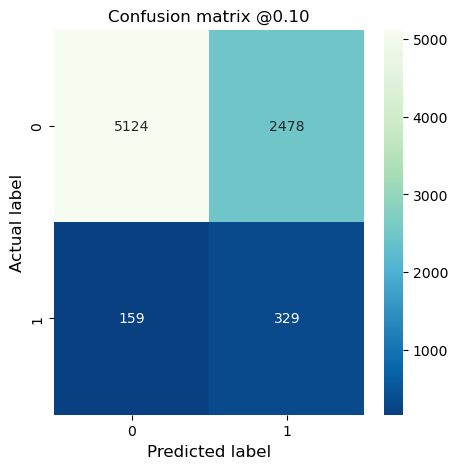

In [35]:
plot_cm(gramtot_predict_dict['gramtot_true'],gramtot_predict_dict['gramtot_ensemble_prob'])

plt.savefig('results/cm_plot.pdf',format = 'pdf',bbox_inches = 'tight', dpi = 500)

# shap

In [40]:
import shap
import time
shap.initjs()

In [41]:
x_train_tot = dev_df[label_features_dict['stay_chart_included_mdr']]

y_train_tot = dev_df['stay_chart_included_mdr']


x_val_tot = val_df[label_features_dict['stay_chart_included_mdr']]

y_val_tot = val_df['stay_chart_included_mdr']

In [155]:
gramtot_rf.fit(x_train_tot, y_train_tot)

RandomForestClassifier(max_depth=9, max_features=0.105, min_samples_split=6,
                       n_estimators=299, random_state=2021)

In [156]:
explainer_tot = shap.Explainer(gramtot_rf)

shap_values_tot = explainer_tot.shap_values(x_val_tot)

In [157]:
explainer_train = shap.Explainer(gramtot_rf)

shap_values_train = explainer_train.shap_values(x_train_tot)

In [158]:
x_val_tot.columns

Index(['dementia', 'platelet', 'phosphate', 'heart_rate', 'weight',
       'creatinine', 'basophils_abs', 'lymphocytes_abs', 'icustay_rank',
       'temperature', 'sodium', 'history_difficulty_swallowing',
       'los_hosp_beforeicu', 'hospstay_seq', 'neutrophils_abs', 'wbc', 'mg',
       'NLR', 'admission_age', 'history_assistive_devices_Wheelchair', 'mchc',
       'history_past_COPD', 'bun', 'rdw', 'previous_mdr_90d'],
      dtype='object')

In [243]:
NAME_RE_DICT = {'sbp':'SBP',
 'weight':'weight',
 'heart_rate':'HR',
 'lactate':'serum lactate',
 'neutrophils_abs':'absolute neutrophil count',
 'anttestR_any':'previous any bacterial resistance',
 'PIPERACILLIN.TAZO_anttest_beforeicu90d':'previous Pip-taz resistance',
 'TOBRAMYCIN_anttest_beforeicu90d':'previous Tobramycin resistance',
 'CEFEPIME_anttest_beforeicu90d':'previous Cefepime resistance',
 'history_past_COPD':'history of COPD',
 'history_iv_access':'history of IV access',
 'immu_duration':'days of immunosuppressant use before ICU admission',
 'bun':'BUN',
 'chloride':'serum chloride',
 'spo2':'SpO$\mathregular{_2}$',
 'eosinophils_abs':'absolute eosinophil count',
 'admission_age':'age',
 'before_adm_90d':'previous hospital admission within 90d',
 'charlson_comorbidity_index':'charlson comorbidity index',
 'ant_duration':'days of antimicrobial use before ICU admission',
 'los_hosp_beforeicu':'days of hospital stay before ICU admission',
 'chronic_pulmonary_disease':'chronic pulmonary disease',
 'creatinine':'serum creatinine',
 'hemoglobin':'hemoglobin',
 'inr':'INR',
 'icustay_rank':'No. of ICU admissions',
 'CEFTRIAXONE_anttest_beforeicu90d':'previous Ceftriaxone resistance',
 'bicarbonate':'bicarbonate',
 'CIPROFLOXACIN_anttest_beforeicu90d':'previous Ciprofloxacin resistance',
 'hospstay_seq':'No. of hospital admissions',
 'history_assistive_devices_Wheelchair':'Wheelchair used as assistive devices',
 'gcs':'GCS',
 'CEFTAZIDIME_anttest_beforeicu90d':'previous Ceftazidime resistance',
 'dbp':'DBP',
 'gender':'gender.Male',
 'sodium':'serum sodium',
 'temperature':'temperature',
 'basophils_abs':'absolute basophil count',
 'mch':'MCH',
 'mchc':'MCHC',
 'lymphocytes_abs':'absolute lymphocyte count',
 'glucose':'glucose',
 'wbc':'WBC',
 'platelet':'platelet',
 'resp_rate':'RR',
 'GENTAMICIN_anttest_beforeicu90d':'previous Gentamicin resistance',
 'calcium':'calcium',
 'mg':'serum magnesium',
 'phosphate':'serum phosphate',               
 'MEROPENEM_anttest_beforeicu90d':'previous Meropenem resistance',
 'history_difficulty_swallowing':'history of difficulty swallowing',
 'mcv':'MCV',
 'history_cv_Pacemaker':'history of CV Pacemaker',
 'potassium':'serum potassium',
 'TRIMETHOPRIM.SULFA_anttest_beforeicu90d':'previous TMP-SMX resistance',
 'shock_index':'shock index',
 'aniongap':'aniongap',
 'rdw':'RDW',
 'monocytes_abs':'absolute monocyte count',
'previous_mdr_90d':'MDRO positive within 90d'}

In [244]:
feature_name_tot = ['dementia',
 'platelet',
 'phosphate',
 'heart_rate',
 'weight',
 'creatinine',
 'basophils_abs',
 'lymphocytes_abs',
 'icustay_rank',
 'temperature',
 'sodium',
 'history_difficulty_swallowing',
 'los_hosp_beforeicu',
 'hospstay_seq',
 'neutrophils_abs',
 'wbc',
 'mg',
 'NLR',
 'admission_age',
 'history_assistive_devices_Wheelchair',
 'mchc',
 'history_past_COPD',
 'bun',
 'rdw',
 'previous_mdr_90d']

feature_name_tot_RE = [NAME_RE_DICT[x] if x in NAME_RE_DICT else x for x in feature_name_tot]

In [245]:
# feature_name_tot = ['absolute eosinophil count', 'DBP', 'chloride', 'days of immunosuppressant use before ICU',
#        'history of diabetes', 'creatinine', 'SBP', 'absolute monocyte count',
#        'temperature', 'calcium', 'absolute basophil count', 'sodium', 'absolute lymphocyte count',
#        'No. of hospital admissions', 'WBC', 'heart_rate', 'MCHC', 'shock index',
#        'absolute neutrophil count', 'No. of ICU admissions',
#        'Wheelchair used as assistive devices', 'hemoglobin', 'BUN', 'RDW',
#        'MDRO positive within 90d']

In [246]:
# feature_name_tot = ['charlson合并症指数', '血肌酐', 'mch', '收缩压', '白细胞计数',
#        '血小板计数', '碳酸氢根离子浓度', '平均红细胞体积', '钙离子浓度', '心率',
#        '体温', '体重', '乳酸浓度', '入院后免疫抑制治疗天数', '氯离子浓度',
#        '中性粒细胞绝对数', '单核细胞绝对数', '钠离子浓度', '血红蛋白浓度', '尿素氮',
#        '红细胞分布宽度', '入院后抗生素治疗天数', '住院次数', '入住ICU次数',
#        '近90天内检出MDR革兰阳性菌']

In [247]:
# feature_name_neg = ['中性粒细胞绝对数', '白细胞计数', 'CO2分压', '呼吸频率', '肌酐', 'ph',
#        '血红蛋白浓度', '淋巴细胞绝对数', '入院后抗生素治疗天数', '体温',
#        '单核细胞绝对数', '钠', 'O2分压', '收缩压', '体重', '血小板计数',
#        '氯离子浓度', '红细胞平均血红蛋白浓度', '入院后免疫抑制治疗天数', '尿素氮', '钙离子浓度', '红细胞分布宽度',
#        '入住ICU次数', '住院次数', '近90天内检出MDR革兰阴性菌']

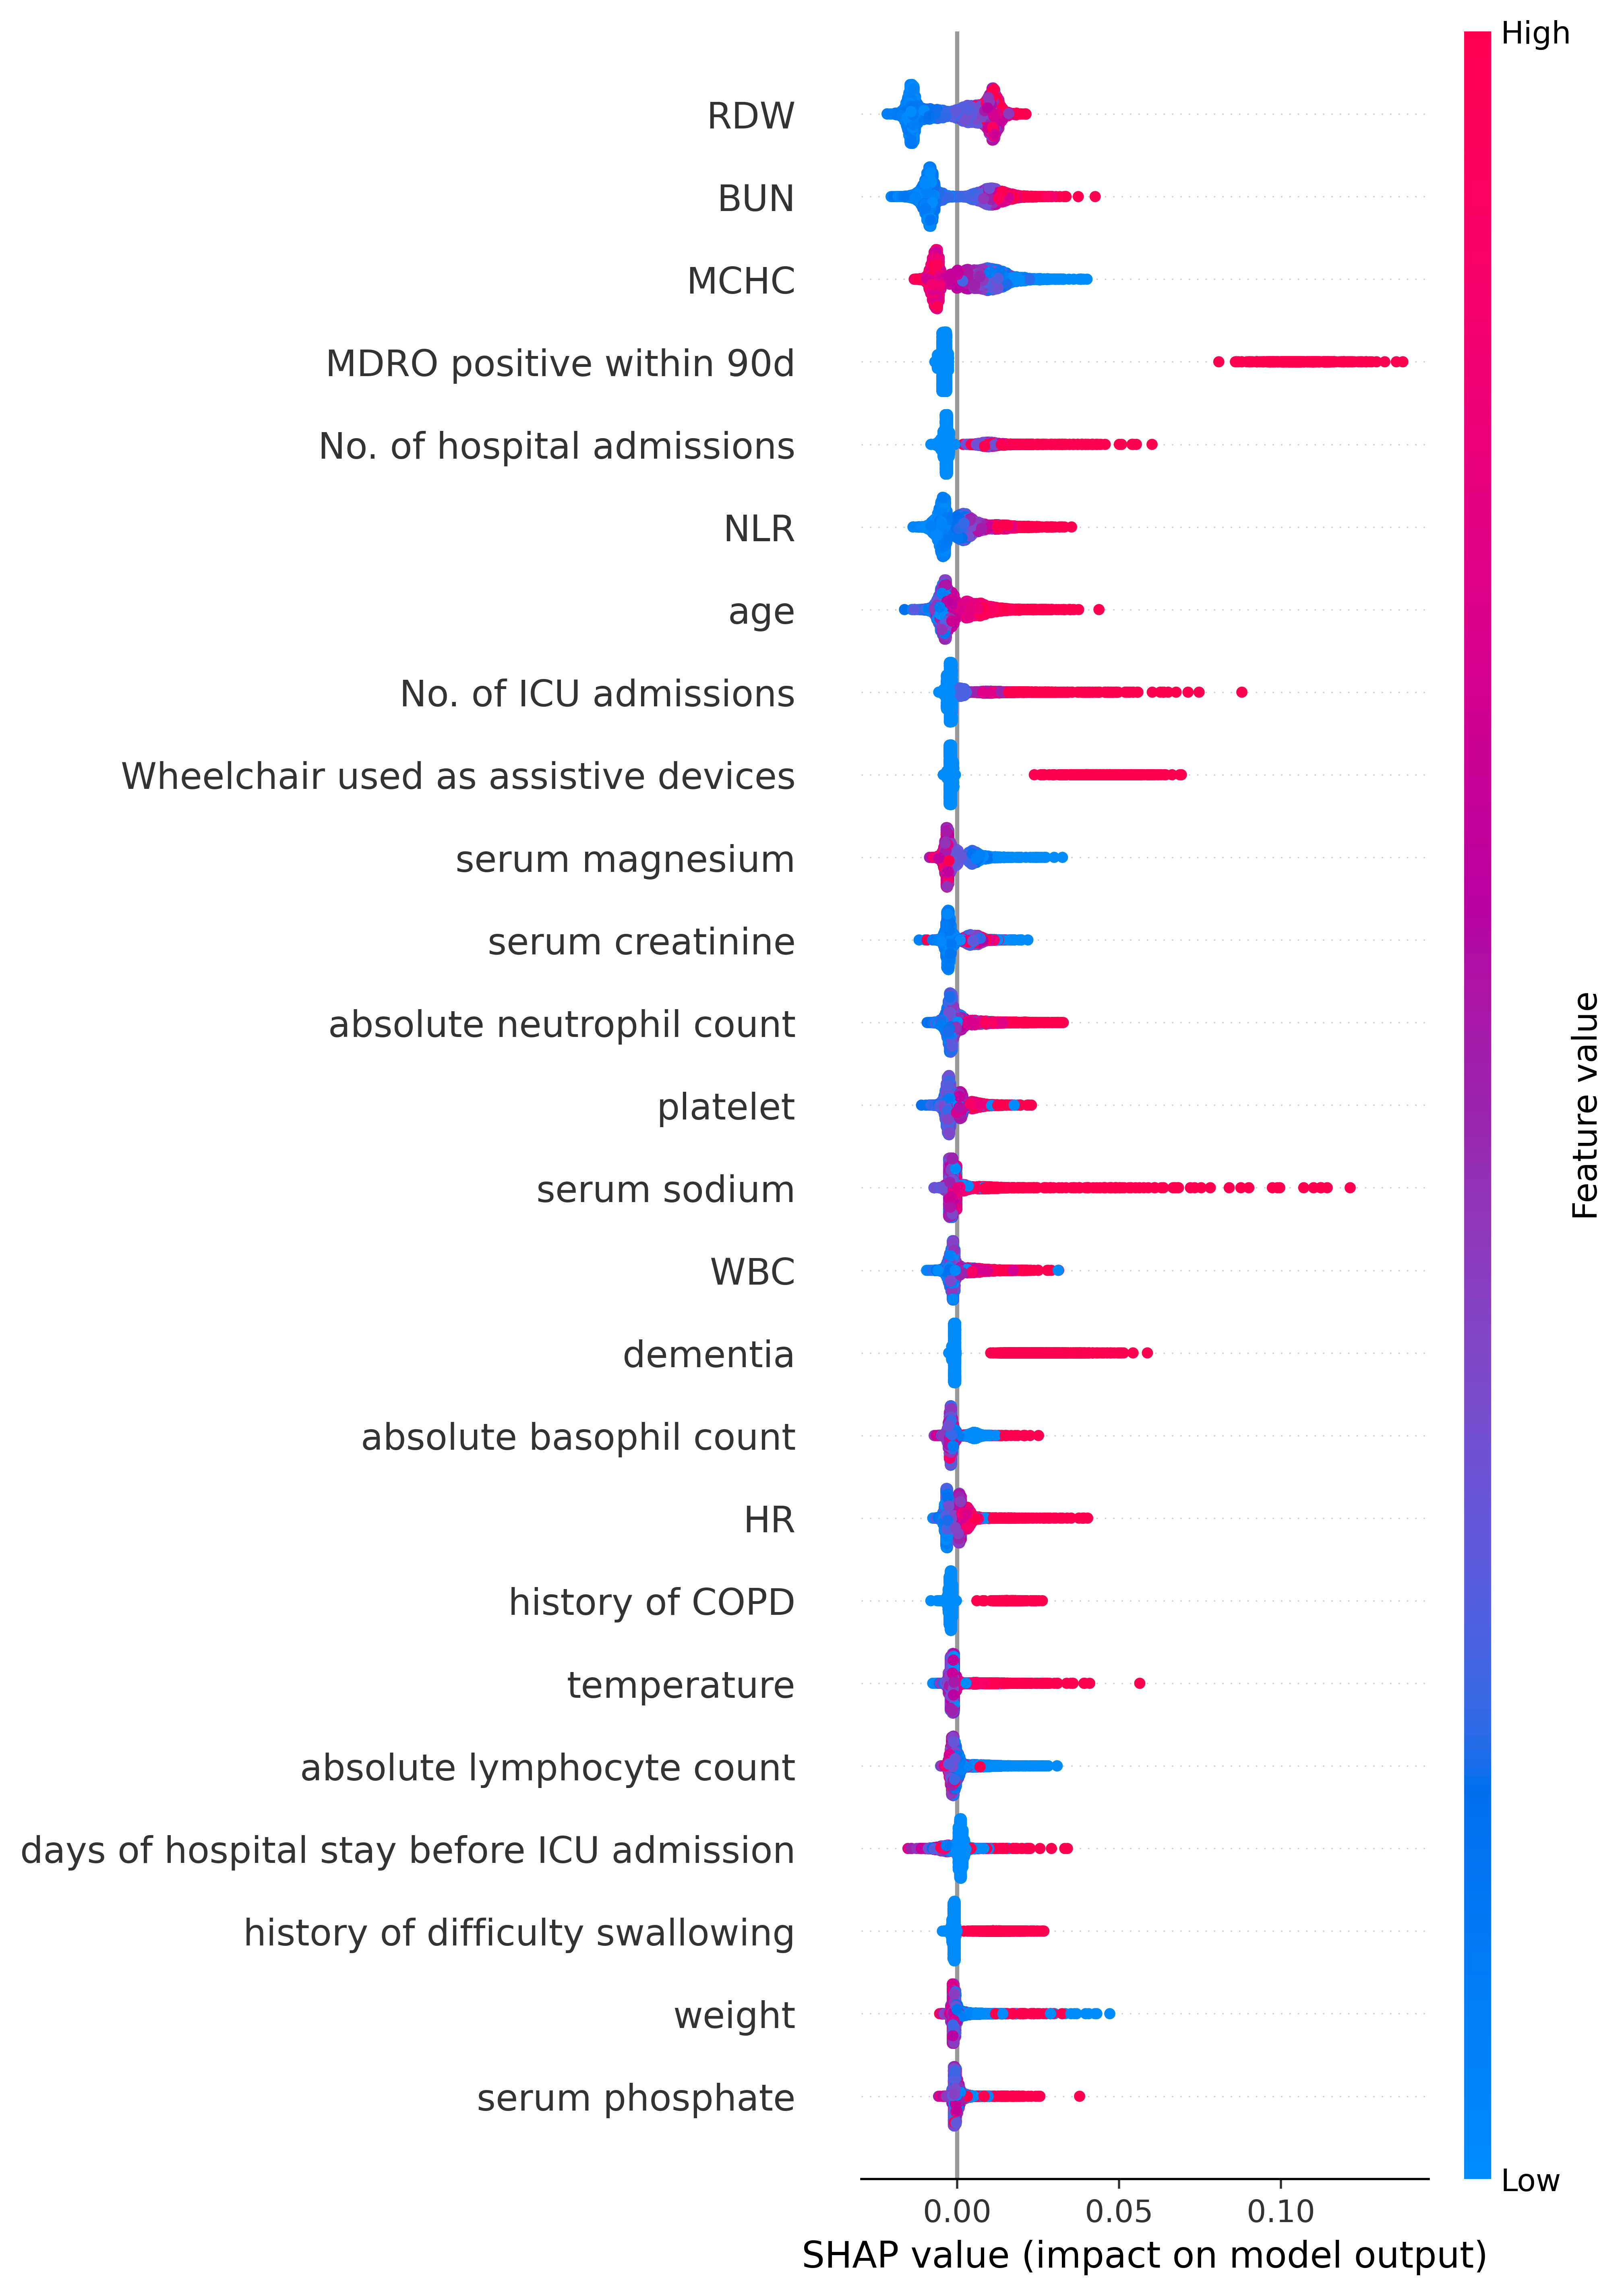

In [248]:
plt.figure(figsize=(12,48),dpi = 500)
# font = {'family' : 'SimHei', 'weight': 'bold', 'size' : '16'}
# plt.rc('font',**font) # 步骤一(设置字体的更多属性)
shap.summary_plot(shap_values_tot[1],features =x_val_tot,
                  feature_names = feature_name_tot_RE, max_display = 25, 
                  plot_type = 'dot',show = False)

#plt.xlabel("x轴")

plt.savefig('results/dot_plot_tot_revise.pdf',format = 'pdf',bbox_inches = 'tight', dpi = 500)

In [ ]:
plt.figure(figsize=(12,12),dpi = 500)
shap.summary_plot(shap_values_train[1],features =x_train_tot,
                  feature_names = feature_name_tot_RE,  
                  plot_type = 'dot',max_display=10)

In [ ]:
plt.figure(figsize=(12,48),dpi = 500)
# font = {'family' : 'SimHei', 'weight': 'bold', 'size' : '16'}
# plt.rc('font',**font) # 步骤一(设置字体的更多属性)
shap.summary_plot(shap_values_train[1],features =x_train_tot,
                  feature_names = feature_name_tot_RE,  
                  plot_type = 'dot')

dementia                                  0.000000
platelet                                140.000000
phosphate                                 6.300000
heart_rate                               60.000000
weight                                   68.800000
creatinine                                3.500000
basophils_abs                             0.000000
lymphocytes_abs                           4.880000
icustay_rank                              1.000000
temperature                              36.440000
sodium                                  149.000000
history_difficulty_swallowing             0.000000
los_hosp_beforeicu                        0.057639
hospstay_seq                              1.000000
neutrophils_abs                           2.440000
wbc                                       6.400000
mg                                        1.600000
NLR                                       0.500000
admission_age                            76.112087
history_assistive_devices_Wheel

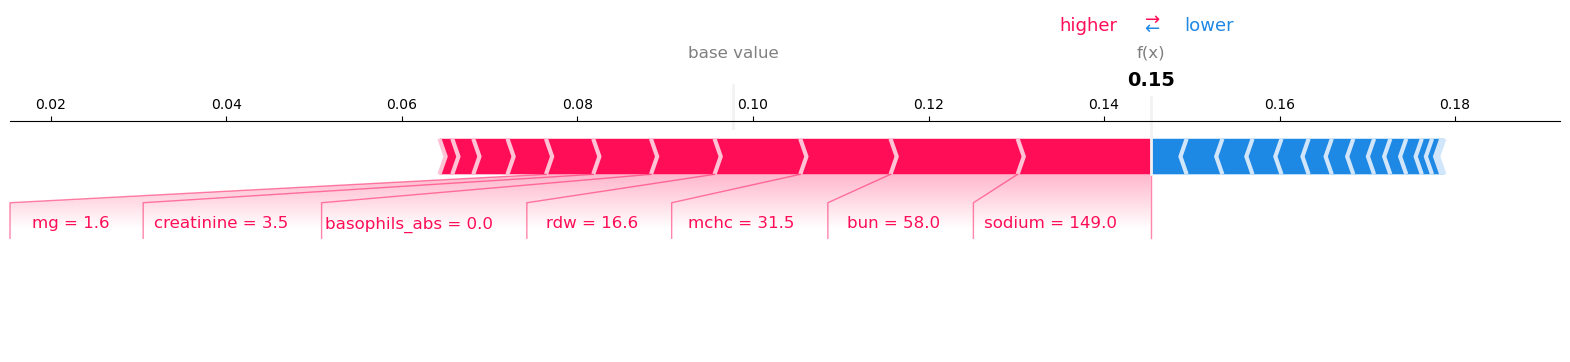

In [221]:
loc_row = 50
print(x_val_tot[x_val_tot.columns].iloc[loc_row,:])
shap.force_plot(explainer_tot.expected_value[1], shap_values_tot[1][loc_row,:],features =x_val_tot.iloc[loc_row,:],matplotlib = True)

dementia                                  0.000000
platelet                                322.000000
phosphate                                 3.800000
heart_rate                               89.000000
weight                                   72.000000
creatinine                                4.000000
basophils_abs                             0.000000
lymphocytes_abs                           2.120000
icustay_rank                              1.000000
temperature                              35.720000
sodium                                  136.000000
history_difficulty_swallowing             0.000000
los_hosp_beforeicu                        0.063889
hospstay_seq                              1.000000
neutrophils_abs                           3.070000
wbc                                       5.900000
mg                                        2.100000
NLR                                       1.448113
admission_age                            78.313306
history_assistive_devices_Wheel

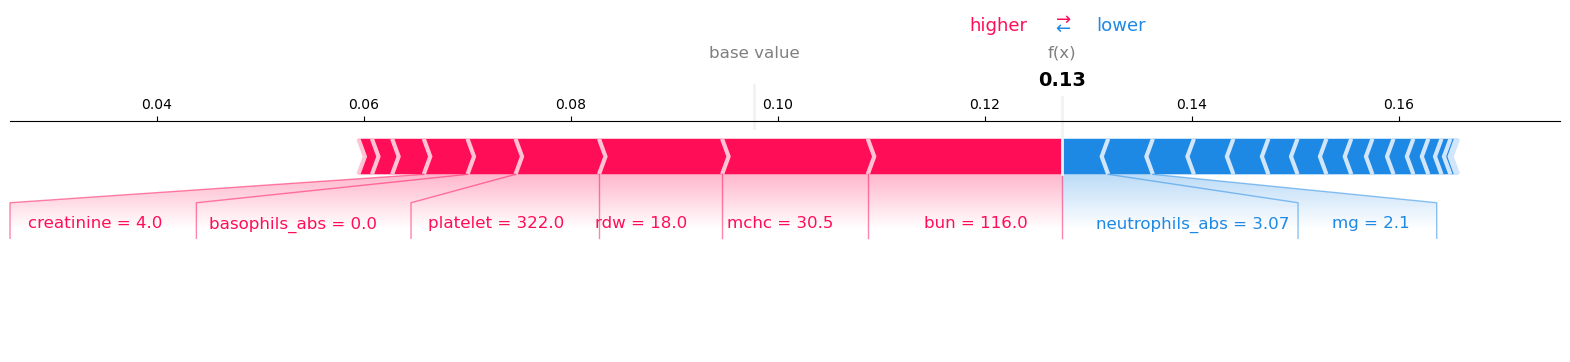

In [224]:
loc_row =85
print(x_val_tot[x_val_tot.columns].iloc[loc_row,:])
shap.force_plot(explainer_tot.expected_value[1], shap_values_tot[1][loc_row,:],features =x_val_tot.iloc[loc_row,:],matplotlib = True)

dementia                                  0.000000
platelet                                104.000000
phosphate                                 5.300000
heart_rate                               77.000000
weight                                   65.000000
creatinine                                1.000000
basophils_abs                             0.060000
lymphocytes_abs                           1.680000
icustay_rank                              1.000000
temperature                              36.440000
sodium                                  138.000000
history_difficulty_swallowing             0.000000
los_hosp_beforeicu                        0.596435
hospstay_seq                              1.000000
neutrophils_abs                          10.590000
wbc                                      13.300000
mg                                        3.000000
NLR                                       6.303571
admission_age                            70.278727
history_assistive_devices_Wheel

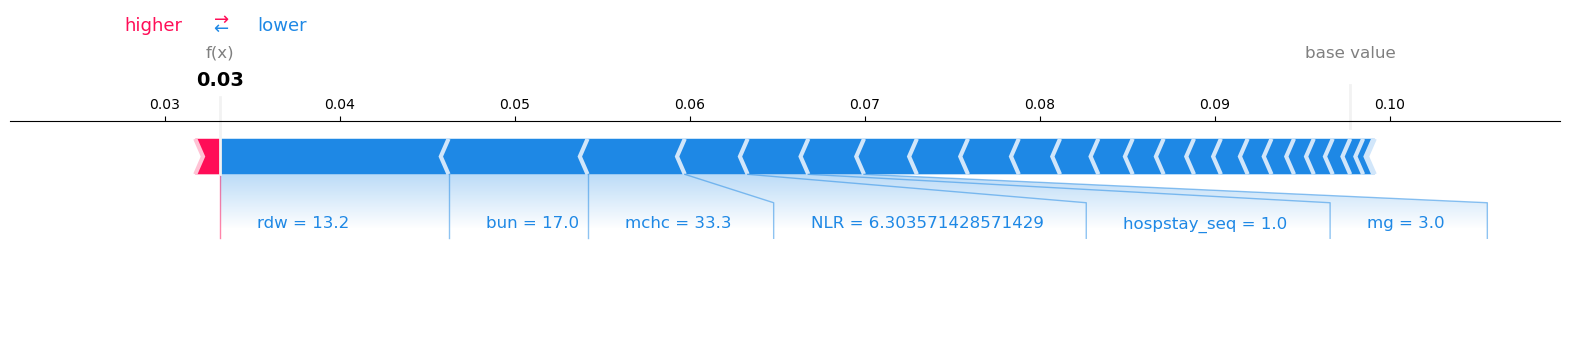

In [230]:
loc_row =4
print(x_val_tot[x_val_tot.columns].iloc[loc_row,:])
shap.force_plot(explainer_tot.expected_value[1], shap_values_tot[1][loc_row,:],features =x_val_tot.iloc[loc_row,:],matplotlib = True)

dementia                                  0.000000
platelet                                 81.000000
phosphate                                 3.500000
heart_rate                               81.000000
weight                                   65.600000
creatinine                                0.600000
basophils_abs                             0.020000
lymphocytes_abs                           0.890000
icustay_rank                              1.000000
temperature                              37.060000
sodium                                  143.000000
history_difficulty_swallowing             0.000000
los_hosp_beforeicu                        0.035417
hospstay_seq                              1.000000
neutrophils_abs                           1.810000
wbc                                       3.300000
mg                                        1.500000
NLR                                       2.033708
admission_age                            57.433933
history_assistive_devices_Wheel

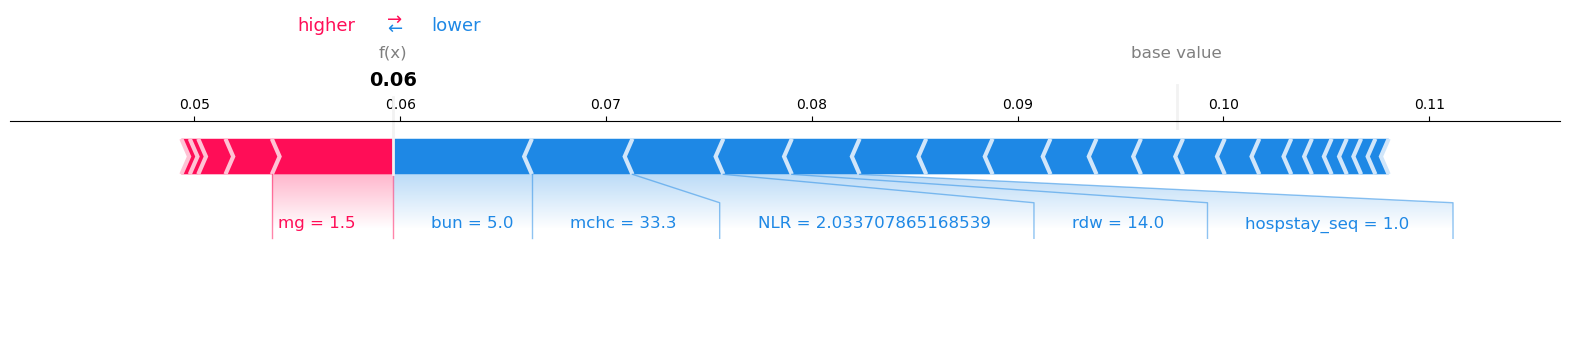

In [236]:
loc_row =10
print(x_val_tot[x_val_tot.columns].iloc[loc_row,:])
shap.force_plot(explainer_tot.expected_value[1], shap_values_tot[1][loc_row,:],features =x_val_tot.iloc[loc_row,:],matplotlib = True)

In [152]:
pd.DataFrame(gramtot_predict_dict).to_csv('results/MIMICIV_posibility_revise.csv',index = False)

In [ ]:
shap.dependence_plot("los_hosp_beforeicu", shap_values_tot[1], x_val_tot, interaction_index= 'previous_mdr_90d')

In [ ]:
shap.dependence_plot("hospstay_seq", shap_values_tot[1], x_val_tot, interaction_index= 'previous_mdr_90d')

In [ ]:
shap.dependence_plot("rdw", shap_values_tot[1], x_val_tot, interaction_index= 'previous_mdr_90d')

In [ ]:
shap.dependence_plot("rdw", shap_values_tot[1], x_val_tot, interaction_index= 'hemoglobin')

In [ ]:
shap.dependence_plot("bun", shap_values_tot[1], x_val_tot, interaction_index= 'previous_mdr_90d')

In [ ]:
shap.dependence_plot("icustay_rank", shap_values_tot[1], x_val_tot, interaction_index= None)

In [ ]:
x_val_tot.columns

In [ ]:
shap.dependence_plot("hemoglobin", shap_values_train[1], x_train_tot, interaction_index= 'previous_mdr_90d')

In [ ]:
shap.dependence_plot("hemoglobin", shap_values_tot[1], x_val_tot, interaction_index= 'rdw')

In [ ]:
shap.dependence_plot("bun", shap_values_tot[1], x_val_tot, interaction_index= 'creatinine')

In [ ]:
shap.dependence_plot("creatinine", shap_values_tot[1], x_val_tot, interaction_index= 'bun')

In [ ]:
shap.dependence_plot("wbc", shap_values_tot[1], x_val_tot, interaction_index= 'bun')

In [ ]:
shap.dependence_plot("neutrophils_abs", shap_values_tot[1], x_val_tot, interaction_index= 'basophils_abs')

In [ ]:
shap.dependence_plot("basophils_abs", shap_values_tot[1], x_val_tot, interaction_index= 'neutrophils_abs')

## 特征重要性排名

In [54]:
import joblib

In [55]:
joblib.dump(gramtot_lr,'lr.pkl')
joblib.dump(gramtot_knn,'knn.pkl')
joblib.dump(gramtot_svc,'svc.pkl')
joblib.dump(gramtot_rf,'rf.pkl')
joblib.dump(gramtot_xgb,'xgb.pkl')
joblib.dump(gramtot_mlp,'mlp.pkl')
joblib.dump(gramtot_ensemble,'ensembler.pkl')

['ensembler.pkl']

In [56]:
models = \
['gramtot_lr',
 'gramtot_knn',
 'gramtot_svc',
 'gramtot_rf',
 'gramtot_xgb',
 'gramtot_mlp',
 'gramtot_ensemble'
]

In [57]:
import re

In [58]:
models_redefined = {re.split('_', i)[1]: i for i in modelsname_all}

In [59]:
model_names = ["lr", "rf", "xgb", "mlp"]

In [60]:
models_redefined = {'lr': gramtot_lr,
 # 'knn': gramtot_knn,
 # 'svc': gramtot_svc,
 'rf': gramtot_rf,
 'xgb': gramtot_xgb,
 'mlp': gramtot_mlp,
 'ensemble': gramtot_ensemble}

In [61]:
# 特征重要性字典
feature_importances = {}

# 提取特征重要性
for name in model_names:
    model = models_redefined[name]
    if name in ["lr"]:
        # 对于逻辑回归和SVC（假设是线性的），使用模型系数
        importance = np.abs(model.coef_[0])
    elif name in ["rf", "xgb"]:
        # 对于随机森林，使用内置的特征重要性
        importance = model.feature_importances_
    elif name == "mlp":
        # 对于MLP，我们将计算第一层权重的绝对值的平均值作为特征重要性（这是一种近似方法）
        importance = np.mean(np.abs(model.coefs_[0]), axis=1)
    feature_importances[name] = importance

# 检查提取的特征重要性
feature_importances.keys()

dict_keys(['lr', 'rf', 'xgb', 'mlp'])

In [62]:
feature_name_tot_RE

['dementia',
 'platelet',
 'phosphate',
 'HR',
 'weight',
 'serum creatinine',
 'absolute basophil count',
 'absolute lymphocyte count',
 'No. of ICU admissions',
 'temperature',
 'serum sodium',
 'history of difficulty swallowing',
 'days of hospital stay before ICU admission',
 'No. of hospital admissions',
 'absolute neutrophil count',
 'WBC',
 'mg',
 'NLR',
 'age',
 'Wheelchair used as assistive devices',
 'MCHC',
 'history of COPD',
 'BUN',
 'RDW',
 'MDRO positive within 90d']

In [63]:
from sklearn.preprocessing import MinMaxScaler

# 将特征重要性转换为DataFrame
feature_importances_df = pd.DataFrame(feature_importances, index=feature_name_tot_RE)

# 标准化特征重要性
scaler = MinMaxScaler()
feature_importances_normalized = pd.DataFrame(
    scaler.fit_transform(feature_importances_df),
    columns=feature_importances_df.columns,
    index=feature_importances_df.index
)

# 查看标准化后的特征重要性
feature_importances_normalized


,lr,rf,xgb,mlp
dementia,0.031588,0.018348,0.151896,0.122433
platelet,0.059052,0.494086,0.004050,0.422506
phosphate,0.026470,0.350150,0.000386,0.139704
HR,0.064020,0.442585,0.000000,0.113979
weight,0.031756,0.504744,0.005335,0.140980
serum creatinine,0.087716,0.467607,0.009693,0.382657
absolute basophil count,0.495331,0.333917,0.008900,0.937042
absolute lymphocyte count,0.083642,0.500509,0.011514,0.933821
No. of ICU admissions,0.000000,0.318867,0.044004,0.179637
temperature,0.077849,0.508205,0.026066,0.000000


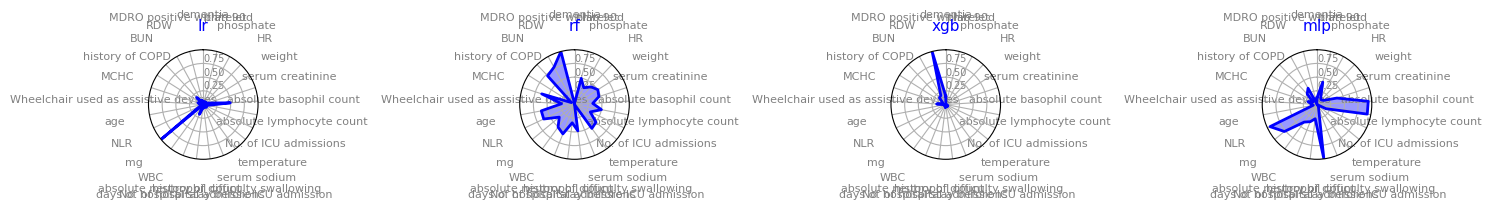

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# 函数：绘制雷达图
def make_spider(row, title, color):
    # 数量的类别
    categories = list(feature_importances_normalized.index)
    N = len(categories)

    # 每个特征重要性之间的角度
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # 绘图
    ax = plt.subplot(1, 4, row+1, polar=True)

    # 第一个轴放在上面
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # 画一个、设置x轴和y轴的位置
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.tick_params(axis='x', which='major', pad=15)

    # 画y轴
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.50, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=7)
    plt.ylim(0,1)

    # 绘制数据
    values = feature_importances_normalized.loc[:, title].values.tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # 添加标题
    plt.title(title, size=11, color=color, y=1.1)

# 创建雷达图
plt.figure(figsize=(15, 5))

# 添加每个模型的特征重要性
for i, model in enumerate(feature_importances_normalized.columns):
    make_spider(i, model, 'b')

plt.tight_layout()
plt.show()


In [72]:
# 函数：绘制雷达图
def make_spider(model, color, ax):
    # 数量的类别
    categories = list(feature_importances_normalized.index)
    N = len(categories)

    # 每个特征重要性之间的角度
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # 绘图
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # 画一个、设置x轴和y轴的位置
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    ax.tick_params(axis='x', which='major', pad=15)

    # 画y轴
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.50, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=7)
    plt.ylim(0,1)

    # 绘制数据
    values = feature_importances_normalized.loc[:, model].values.tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, color=color, alpha=0.4)

# # 创建雷达图
# plt.figure(figsize=(10, 10))
# ax = plt.subplot(111, polar=True)

# # 添加每个模型的特征重要性
# colors = ['blue', 'green', 'red','black']
# for i, model in enumerate(feature_importances_normalized.columns):
#     make_spider(model, colors[i], ax)

# # 添加图例
# plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# plt.show()

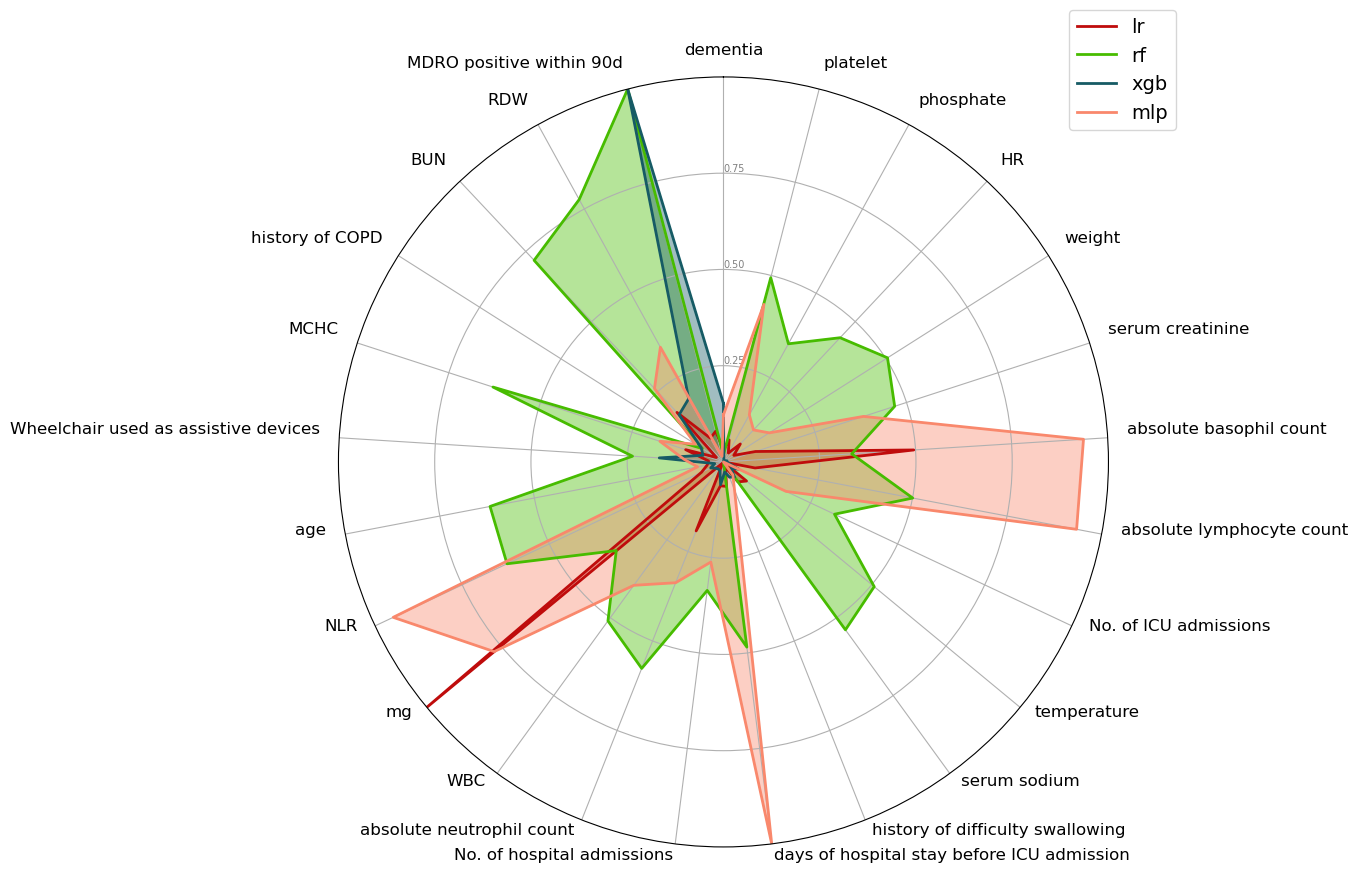

In [73]:
# 重新调整雷达图，保留竖直网格线并确保特征名称位置正确

# 创建雷达图
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
colors =['#bf0c0c','#47bc00','#165b65','#f9886c']

# 添加每个模型的特征重要性
for i, model in enumerate(feature_importances_normalized.columns):
    make_spider(model, colors[i], ax)

# 特征名称的位置调整
# 恢复默认的标签（网格线）
labels = list(feature_importances_normalized.index)
angles = [n / float(len(labels)) * 2 * np.pi for n in range(len(labels))]
angles += angles[:1]  # 完成循环

plt.xticks(angles[:-1], [])  # 移除原有标签文字，保留网格线

# 添加新的特征名称标签
for label, angle in zip(labels, angles[:-1]):
    if angle in [0, np.pi]:
        ha, va = "center", "bottom"
    elif 0 < angle < np.pi:
        ha, va = "left", "bottom"
    elif np.pi < angle < 2*np.pi:
        ha, va = "right", "bottom"
    else: # angle == np.pi
        ha, va = "center", "top"

    ax.text(angle, 1.05, label, size=12, horizontalalignment=ha, verticalalignment=va)

# 添加图例
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1),fontsize=14)


plt.savefig('results/MIMICIV_feature_importance_radar_chart_revise.pdf', format='pdf', bbox_inches='tight')
plt.show()

# sensitivity analysis

In [106]:
df_tot = pd.read_csv('../0.Data_process/data_tomodel_1st_revise.csv')

In [107]:
val_df_tot = df_tot[df_tot['stay_id'].isin(val_df.stay_id)]

In [111]:
val_df_tot['lymphocytes_abs'] = val_df_tot['lymphocytes_abs'].replace(0, 0.001)
val_df_tot['NLR'] = val_df_tot['neutrophils_abs']/val_df_tot['lymphocytes_abs']

In [112]:
val_df_tot['previous_mdr_90d'] = (val_df_tot['previous_mdrpos_lessthan90d'] + val_df_tot['previous_mdrneg_lessthan90d']).apply(lambda x:1 if x>=1 else 0)

In [113]:
val_df_tot['gender'] = val_df_tot['gender'].apply(lambda x:1 if x == 'F' else 0)

In [114]:
val_df_com = val_df_tot[['dementia',
 'platelet',
 'phosphate',
 'heart_rate',
 'weight',
 'creatinine',
 'basophils_abs',
 'lymphocytes_abs',
 'icustay_rank',
 'temperature',
 'sodium',
 'history_difficulty_swallowing',
 'los_hosp_beforeicu',
 'hospstay_seq',
 'neutrophils_abs',
 'wbc',
 'mg',
 'NLR',
 'admission_age',
 'history_assistive_devices_Wheelchair',
 'mchc',
 'history_past_COPD',
 'bun',
 'rdw',
 'previous_mdr_90d',
 'stay_chart_included_mdr'
]]

In [115]:
pd.isna(val_df_com).sum()

dementia                                  0
platelet                                  2
phosphate                               226
heart_rate                                2
weight                                  112
creatinine                                6
basophils_abs                             3
lymphocytes_abs                           0
icustay_rank                              0
temperature                             175
sodium                                    0
history_difficulty_swallowing             0
los_hosp_beforeicu                        0
hospstay_seq                              0
neutrophils_abs                           3
wbc                                       0
mg                                      144
NLR                                       3
admission_age                             0
history_assistive_devices_Wheelchair      0
mchc                                      3
history_past_COPD                         0
bun                             

In [116]:
val_df_complete = val_df_com.dropna()

In [117]:
val_df_complete.describe()

,dementia,platelet,phosphate,heart_rate,weight,creatinine,basophils_abs,lymphocytes_abs,icustay_rank,temperature,...,mg,NLR,admission_age,history_assistive_devices_Wheelchair,mchc,history_past_COPD,bun,rdw,previous_mdr_90d,stay_chart_included_mdr
count,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000,...,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000,7622.000000
mean,0.074915,211.857649,3.861467,91.520336,81.040134,1.586841,0.035820,1.453791,1.793099,36.831071,...,1.983810,152.051458,65.892622,0.041853,32.255773,0.023222,29.116898,15.381698,0.032275,0.061926
std,0.263271,115.694858,1.698381,20.842623,25.089559,1.810848,0.045328,3.580945,2.166980,0.727656,...,0.593662,2437.087430,16.996395,0.200265,1.756110,0.150619,25.093607,2.738951,0.176741,0.241037
min,0.000000,5.000000,0.500000,32.000000,1.000000,0.200000,0.000000,0.001000,1.000000,29.940000,...,0.600000,0.000000,18.255951,0.000000,24.200000,0.000000,1.000000,10.800000,0.000000,0.000000
25%,0.000000,138.000000,2.900000,77.000000,64.400000,0.700000,0.010000,0.660000,1.000000,36.560000,...,1.700000,4.208005,55.918170,0.000000,31.100000,0.000000,13.000000,13.400000,0.000000,0.000000
50%,0.000000,197.000000,3.600000,89.000000,77.100000,1.000000,0.030000,1.100000,1.000000,36.830000,...,1.900000,8.067930,67.747237,0.000000,32.400000,0.000000,20.000000,14.600000,0.000000,0.000000
75%,0.000000,264.750000,4.400000,105.000000,93.100000,1.600000,0.050000,1.720000,2.000000,37.110000,...,2.200000,15.430247,78.384350,0.000000,33.400000,0.000000,36.000000,16.700000,0.000000,0.000000
max,1.000000,1233.000000,58.000000,206.000000,297.700000,32.900000,1.580000,222.850000,33.000000,41.200000,...,27.300000,98780.000000,102.865603,1.000000,40.000000,1.000000,213.000000,33.000000,1.000000,1.000000


In [120]:
# 载入模型
gramtot_lr = joblib.load('lr.pkl')
gramtot_knn = joblib.load('knn.pkl')
gramtot_svc = joblib.load('svc.pkl')
gramtot_rf = joblib.load('rf.pkl')
gramtot_xgb = joblib.load('xgb.pkl')
gramtot_mlp = joblib.load('mlp.pkl')
gramtot_ensemble = joblib.load('ensembler.pkl')

# 定义模型列表
models = [gramtot_lr, gramtot_knn, gramtot_svc, gramtot_rf, gramtot_xgb, gramtot_mlp, gramtot_ensemble]

# 提取特征
x_ext = val_df_complete.drop(columns=['stay_chart_included_mdr'])  
y_ext = val_df_complete['stay_chart_included_mdr']

# 对数据进行标准化以及预测
predictions = {}
for model in models:
    model_name = type(model).__name__
    if model_name in ['SVC', 'LogisticRegression', 'MLPClassifier', 'KNeighborsClassifier']:
        scaler = MinMaxScaler()
        scaler.fit(dev_df[label_features_dict['stay_chart_included_mdr']])
        x_ext_scaled = pd.DataFrame(scaler.transform(x_ext))
        predict_ext = model.predict_proba(x_ext_scaled)
    else:
        predict_ext = model.predict_proba(x_ext)

    predictions[model_name] = predict_ext

# 输出预测结果
for model_name, prediction in predictions.items():
    print(f"Predictions for {model_name}:")
    print(prediction)

# 如果希望将所有预测结果写入到一个文件，可以考虑以下代码：
# with open("predictions.txt", "w") as file:
#     for model_name, prediction in predictions.items():
#         file.write(f"Predictions for {model_name}:\n")
#         file.write(f"{prediction}\n")

Predictions for LogisticRegression:
[[0.89405636 0.10594364]
 [0.92869727 0.07130273]
 [0.92581543 0.07418457]
 ...
 [0.93973232 0.06026768]
 [0.95898644 0.04101356]
 [0.91555051 0.08444949]]
Predictions for KNeighborsClassifier:
[[0.8274739  0.1725261 ]
 [0.98030834 0.01969166]
 [0.94134004 0.05865996]
 ...
 [0.92159476 0.07840524]
 [0.98270856 0.01729144]
 [0.88529329 0.11470671]]
Predictions for SVC:
[[0.76662142 0.23337858]
 [0.76844612 0.23155388]
 [0.76814274 0.23185726]
 ...
 [0.7715372  0.2284628 ]
 [0.77132504 0.22867496]
 [0.76399437 0.23600563]]
Predictions for RandomForestClassifier:
[[0.84964879 0.15035121]
 [0.93700229 0.06299771]
 [0.93824428 0.06175572]
 ...
 [0.93955557 0.06044443]
 [0.96065586 0.03934414]
 [0.91548951 0.08451049]]
Predictions for XGBClassifier:
[[0.77956146 0.22043853]
 [0.8892844  0.11071566]
 [0.883832   0.11616802]
 ...
 [0.8748431  0.12515686]
 [0.9102145  0.08978552]
 [0.85534173 0.14465827]]
Predictions for MLPClassifier:
[[0.87453398 0.12546602

In [146]:
comp_val = dict()
for model_name, prediction in predictions.items():
    comp_val[model_name]=prediction[:,1]
    print(model_name)
    print(roc_auc_score(val_df_complete['stay_chart_included_mdr'],prediction[:,1]))
    print('----------------------------------')
comp_val = pd.DataFrame(comp_val)

comp_val = pd.concat([comp_val,val_df_complete['stay_chart_included_mdr'].reset_index(drop = True)],axis = 1)

LogisticRegression
0.7195146379044685
----------------------------------
KNeighborsClassifier
0.7002152720161194
----------------------------------
SVC
0.6766415787602228
----------------------------------
RandomForestClassifier
0.7500696337560745
----------------------------------
XGBClassifier
0.7369944885622851
----------------------------------
MLPClassifier
0.7029823989569752
----------------------------------
StackingClassifier
0.7456278890600926
----------------------------------


In [147]:
comp_val.to_csv('results/MIMICIV_posibility_sens_analysis.csv',index = False)

In [149]:
comp_val

,LogisticRegression,KNeighborsClassifier,SVC,RandomForestClassifier,XGBClassifier,MLPClassifier,StackingClassifier,stay_chart_included_mdr
0,0.105944,0.172526,0.233379,0.150351,0.220439,0.125466,0.131396,0
1,0.071303,0.019692,0.231554,0.062998,0.110716,0.048144,0.060768,0
2,0.074185,0.058660,0.231857,0.061756,0.116168,0.055604,0.061954,0
3,0.160984,0.284673,0.315998,0.158530,0.229047,0.476192,0.198266,0
4,0.030390,0.019001,0.232779,0.033139,0.089291,0.012455,0.045839,0
...,...,...,...,...,...,...,...,...
7617,0.070631,0.077060,0.237887,0.099315,0.144456,0.070119,0.079471,0
7618,0.077477,0.152646,0.236206,0.103686,0.144116,0.094436,0.083531,0
7619,0.060268,0.078405,0.228463,0.060444,0.125157,0.055749,0.061852,0
7620,0.041014,0.017291,0.228675,0.039344,0.089786,0.028757,0.048670,0


In [150]:
#补充f1_score

import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix, f1_score

# Assuming `confidence_interval_new` is a predefined function

fpr, tpr, thresholds = roc_curve(comp_val['stay_chart_included_mdr'], comp_val['RandomForestClassifier'])

cutoff_l = []
num_l = []
acc_l = []
sens_l = []
spec_l = []
ppv_l = []
npv_l = []
f1_l = []

for i in thresholds:
    test = comp_val[['stay_chart_included_mdr', 'RandomForestClassifier']]
    test['predict'] = (test['RandomForestClassifier'] > i).apply(int)
    cm = confusion_matrix(test['stay_chart_included_mdr'], test['predict'])
    num = cm[0][1] + cm[1][1]
    acc_str, sens_str, spec_str, ppv_str, npv_str = confidence_interval_new(cm)

    # Calculate F1-score
    f1 = f1_score(test['stay_chart_included_mdr'], test['predict'])

    cutoff_l.append(i)
    num_l.append(num)
    acc_l.append(acc_str)
    sens_l.append(sens_str)
    spec_l.append(spec_str)
    ppv_l.append(ppv_str)
    npv_l.append(npv_str)
    f1_l.append(f1)

all_cutoff = pd.DataFrame({'截断值': cutoff_l, '数量': num_l, '准确率 (%)': acc_l, '灵敏度 (%)': sens_l,
                           '特异度 (%)': spec_l, '阳性预告值 (%)': ppv_l, '阴性预告值 (%)': npv_l, 'F1-score': f1_l})

num_stard = []
t = 0
for i in range(11):
    g = 10685 / 11
    t = g * i
    num_stard.append(t)

q_find = []
for i in num_stard:
    aa = []
    bb = []

    for j in all_cutoff['数量']:
        de = abs(i - j)
        aa.append(j)
        bb.append(de)

    find_m = bb.index(min(bb))
    q_find.append(aa[find_m])

result = all_cutoff[all_cutoff['数量'].isin(list(set(q_find)))].sort_values(by='截断值').reset_index(drop=True).head(10)
print(result)

        截断值    数量 准确率 (%) 灵敏度 (%) 特异度 (%) 阳性预告值 (%) 阴性预告值 (%)  F1-score
0  0.026592  7621    6.21   100.0    0.01      6.19     100.0  0.116644
1  0.046752  6812   16.71   99.15   11.27      6.87     99.51  0.128501
2  0.062787  5861   28.72   95.34   24.32      7.68     98.75  0.142113
3  0.077797  4885   40.87   90.04   37.62       8.7     98.28  0.158671
4  0.092400  3885   53.12   83.05   51.15     10.09     97.86  0.179940
5  0.107045  2913   64.48   71.82    64.0     11.64     97.18  0.200295
6  0.125112  1930   75.54   56.99   76.77     13.94     96.43  0.223980
7  0.155399   970    85.8   38.14   88.95     18.56     95.61  0.249653
8  0.435610     0   93.81     0.0   100.0       nan     93.81  0.000000
9  1.435610     0   93.81     0.0   100.0       nan     93.81  0.000000


In [151]:
result

,截断值,数量,准确率 (%),灵敏度 (%),特异度 (%),阳性预告值 (%),阴性预告值 (%),F1-score
0,0.026592,7621,6.21,100.0,0.01,6.19,100.0,0.116644
1,0.046752,6812,16.71,99.15,11.27,6.87,99.51,0.128501
2,0.062787,5861,28.72,95.34,24.32,7.68,98.75,0.142113
3,0.077797,4885,40.87,90.04,37.62,8.7,98.28,0.158671
4,0.092400,3885,53.12,83.05,51.15,10.09,97.86,0.179940
5,0.107045,2913,64.48,71.82,64.0,11.64,97.18,0.200295
6,0.125112,1930,75.54,56.99,76.77,13.94,96.43,0.223980
7,0.155399,970,85.8,38.14,88.95,18.56,95.61,0.249653
8,0.435610,0,93.81,0.0,100.0,nan,93.81,0.000000
9,1.435610,0,93.81,0.0,100.0,nan,93.81,0.000000
